In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import h5py
import numpy
from PIL import Image

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.ma as ma
import os
import natsort

import pylab
# A random colormap for matplotlib
colors = numpy.random.rand ( 256,3)
colors[0] = [0, 0, 0]
cmap = matplotlib.colors.ListedColormap ( colors) 


In [2]:
def two_color_coded(a):

    pos = np.zeros_like(a)
    neg = np.zeros_like(a)
    zero = np.zeros_like(a)

    idx = a > 0
    if np.sum(idx) > 0:
        pos[idx] = a[idx] #/ float(np.max(data[idx]))
    idx = a < 0
    if np.sum(idx) > 0:
        neg[idx] = a[idx] * (-1) #/ float(np.min(data[idx]))

    color = np.stack([pos, neg, zero], axis=-1)

    return color

keys: <KeysViewHDF5 ['volumes']>
crop  [46 46 46]
raw (3, 36, 36, 36) affs (36, 36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0230091 0.5110036
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0165236 0.5791447
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.032856 0.47237083
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0139009 0.6217287
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -0.99166274 0.6643881
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -0.9961847 0.6704
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -0.9997499 0.52520806
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0473753 0.24289082
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0041214 0.43214393
dt pred  (36, 36)
raw:  float32 0.0 1.0
pred:  float32 -1.0163152 0.45418334
dt pred  (36, 36)


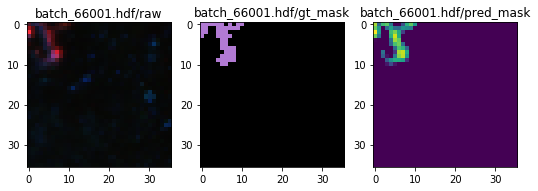

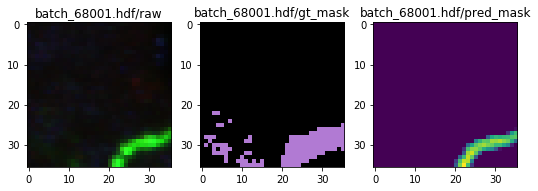

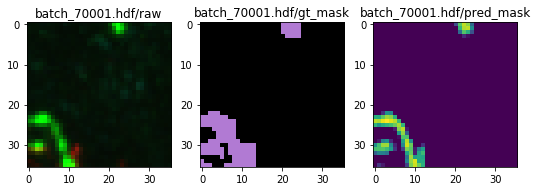

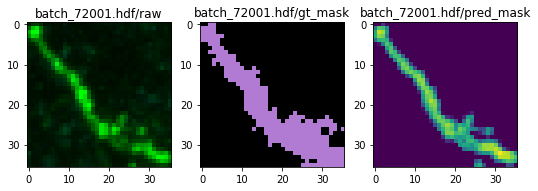

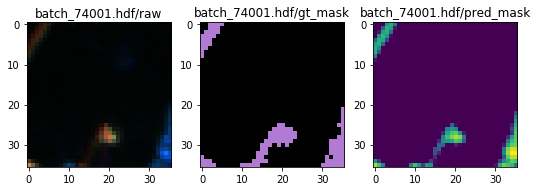

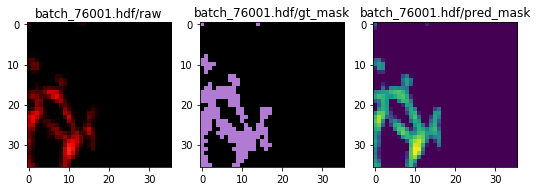

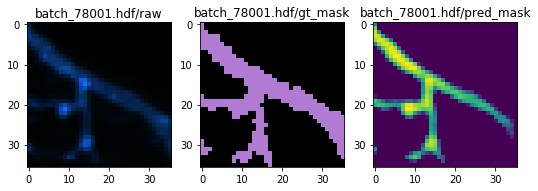

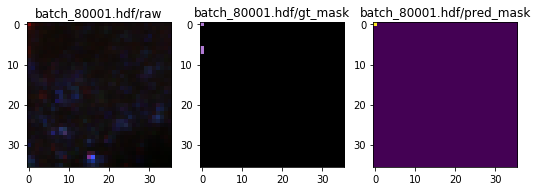

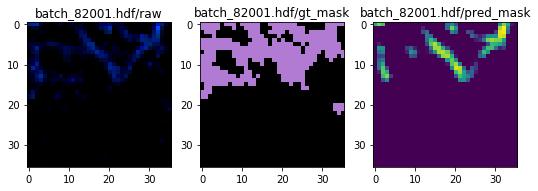

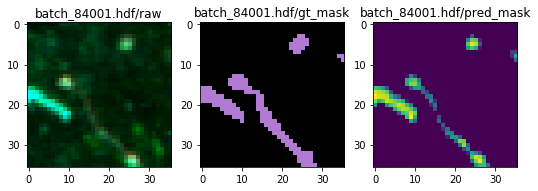

In [3]:
root = '/groups/kainmueller/home/maisl/workspace/neurolight/experiments'
experiments = [#'setup04_070419_00', 
               #'setup02_030419_00', 
               #'setup05_070419_01', 
               #'setup04_00050419', 
               #'setup05_01050419', 
               #'setup06_070419_00',  
               #'setup07_070419_00', 
               #'setup08_080419_00',
               #'setup09_090419_00', 
               'setup10_090419_00',
               #'setup11_100419_00',
                ]
expid = 0
experiment = experiments[expid]
sn='snapshots'

sn_path = os.path.join(root, experiment, 'train', sn)
snapshots = os.listdir(sn_path)
snapshots = natsort.natsorted(snapshots)
snapshots = snapshots[-10:]

num_padded=0

for nidx, name in enumerate(snapshots):

    ext = os.path.splitext(name)[1]
    if ext != ".hdf": continue
    try:
        with h5py.File(os.path.join(sn_path, name), 'r') as f:
            keys = f.keys()
            if nidx==0:
                print("keys: %s" % keys)
            raw = np.array(f['volumes/raw'])
            labels = np.array(f['volumes/gt_mask'])
            pred = np.array(f['volumes/pred_dt'])
            if 'gradient' in f['volumes'].keys():
                gradient = np.array(f['volumes/gradient'])
            else:
                gradient = None
            #hsl = np.array(f['volumes/hsl'])
            
    except:
        print("loading failed for %s, raw %s labels %s" % (sn_path+name, raw.shape, labels.shape))
        continue
    
    crop = ((np.array(raw.shape[1:])-np.array(labels.shape[0:]))/2).astype(int)

    raw = raw[:,crop[0]:-crop[0],crop[1]:-crop[1],crop[2]:-crop[2]]
    raw = (raw + np.abs(np.min(raw))) / (np.max(raw) + np.abs(np.min(raw)))
    if nidx==0:
        print("crop ", crop)
        print("raw", raw.shape, "affs", labels.shape)

    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,5,1)
    plt.title(name+'/raw')
    print('raw: ', raw.dtype, np.min(raw), np.max(raw))
    raw = np.max(raw, axis=1)
    pylab.imshow(np.moveaxis(raw,0,2))
    
    """hsl = hsl[:,crop[0]:-crop[0],crop[1]:-crop[1],crop[2]:-crop[2]]
    fig.add_subplot(1,5,2)
    plt.title(name+'/hsl')
    for i in range(3):
        if np.min(hsl[i]) < 0:
            hsl[i] += np.abs(np.min(hsl[i]))
    print('hsl: ', hsl.dtype, hsl.shape, np.min(hsl), np.max(hsl))
    hsl = np.max(hsl, axis=1)
    pylab.imshow(np.moveaxis(hsl,0,2))"""

    # gt mask
    fig.add_subplot(1,5,2)
    plt.title(name + '/gt_mask')
    #print('gt mask: ', labels.dtype, np.min(labels), np.max(labels))
    mip = np.max(labels, axis=0)
    pylab.imshow(mip, cmap=cmap)

    # pred
    fig.add_subplot(1,5,3)
    plt.title(name + '/pred_mask')
    print('pred: ', pred.dtype, np.min(pred), np.max(pred))
    #rgb = two_color_coded(pred)
   # print("rgb pred ", rgb.shape)
    pos = np.zeros_like(pred)
    thresh = 0
    pos[pred>thresh] = pred[pred>thresh]
    mip = np.max(pos, axis=0)
    print("dt pred ", mip.shape)
    plt.imshow(mip)
    
    # gradient
    """if gradient is not None:
        
        fig.add_subplot(1,5,4)
        plt.title(name + '/gradient')
        print(gradient.shape)
        print('gradient: ', gradient.dtype, gradient.shape, np.min(gradient), np.max(gradient))
        posgrad = np.zeros_like(gradient)
        neggrad = np.zeros_like(gradient)
        zerograd = np.zeros_like(gradient)
        
        idx = gradient > 0
        if np.sum(idx) > 0:
            posgrad[idx] = gradient[idx] / float(np.max(gradient[idx]))
        idx = gradient == 0
        #zerograd[idx] = 1
        idx = gradient < 0
        if np.sum(idx) > 0:
            neggrad[idx] = gradient[idx] / float(np.min(gradient[idx]))
        print('neggrad: ', np.max(neggrad))
        
        mip = np.stack([
            np.max(posgrad, axis=0), #red
            np.max(neggrad, axis=0), #green
            np.max(zerograd, axis=0), #blue
        ],
        axis=-1)
        plt.imshow(mip)"""
    